# Modeling:

**NOTA**: 

- La ubicación sigue siendo demasiado importante en el modelo (hay que encontrar la manera de contrarrestarla)
- Sigue habiendo desbalance de clases (la categoría _daño medio_ está sobrerepresentada en comparación con el resto). Es, sin duda, donde más falla el modelo.
    - Resampleado? Cross validation? Sampleado estratificado?

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ML Libraries
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Librerías cargadas!")

✅ Librerías cargadas!


In [2]:
# Cargar datos
DATA_DIR = Path("../data/raw")
train_values = pd.read_csv(DATA_DIR / "train_values.csv", index_col="building_id")
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv", index_col="building_id")
test_values = pd.read_csv(DATA_DIR / "test_values.csv", index_col="building_id")

print(f"Train: {train_values.shape}")
print(f"Test: {test_values.shape}")

Train: (260601, 38)
Test: (86868, 38)


In [3]:
def create_features(df):
    """Crear features basadas en el EDA."""
    df = df.copy()
    
    # Materiales débiles
    weak_materials = [
        'has_superstructure_mud_mortar_stone',
        'has_superstructure_stone_flag',
        'has_superstructure_adobe_mud',
        'has_superstructure_mud_mortar_brick',
        'has_superstructure_bamboo'
    ]
    df['weak_material_count'] = df[weak_materials].sum(axis=1)
    
    # Materiales fuertes
    strong_materials = [
        'has_superstructure_rc_engineered',
        'has_superstructure_rc_non_engineered',
        'has_superstructure_cement_mortar_brick',
        'has_superstructure_cement_mortar_stone'
    ]
    df['strong_material_count'] = df[strong_materials].sum(axis=1)
    
    # Índice de vulnerabilidad
    df['vulnerability_score'] = df['weak_material_count'] - df['strong_material_count']
    
    # Características estructurales
    df['age_x_floors'] = df['age'] * df['count_floors_pre_eq']
    df['height_area_ratio'] = df['height_percentage'] / (df['area_percentage'] + 1)
    df['families_per_floor'] = df['count_families'] / (df['count_floors_pre_eq'] + 1)
    
    # Categorías de edad
    df['is_old'] = (df['age'] > 25).astype(int)
    df['is_very_old'] = (df['age'] > 50).astype(int)
    
    # Total superstructure
    superstructure_cols = [col for col in df.columns if 'has_superstructure' in col]
    df['total_superstructure_types'] = df[superstructure_cols].sum(axis=1)
    
    # Secondary use
    secondary_cols = [col for col in df.columns if 'has_secondary_use_' in col]
    df['total_secondary_uses'] = df[secondary_cols].sum(axis=1)
    
    # Geographic risk
    high_risk_regions = [17, 18, 21, 8, 27, 28]
    low_risk_regions = [26, 24, 5, 20, 13, 1]
    df['is_high_risk_region'] = df['geo_level_1_id'].isin(high_risk_regions).astype(int)
    df['is_low_risk_region'] = df['geo_level_1_id'].isin(low_risk_regions).astype(int)
    
    return df

# Aplicar feature engineering
train_fe = create_features(train_values)
test_fe = create_features(test_values)

print(f"Features totales: {train_fe.shape[1]}")

Features totales: 50


In [4]:
def preprocess_for_lgbm(train_df, test_df):
    """Preparar datos para LightGBM."""
    
    # Identificar columnas categóricas
    cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
    
    # Label encoding
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
        le.fit(combined)
        train_df[col] = le.transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))
        label_encoders[col] = le
    
    return train_df, test_df, cat_cols

# Preprocesar
X, X_test, cat_cols = preprocess_for_lgbm(train_fe.copy(), test_fe.copy())
y = train_labels['damage_grade'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Categorical columns: {cat_cols}")

X shape: (260601, 50)
y shape: (260601,)
Categorical columns: ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']


In [5]:
def train_lgbm_cv(X, y, X_test, n_splits=5):
    """Entrenar LightGBM con CV."""
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    # Almacenar resultados
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros((len(X_test), 3))  # 3 clases
    scores = []
    feature_importance = []
    
    # Parámetros LightGBM
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': 500,
        'learning_rate': 0.05,
        'num_leaves': 100,
        'max_depth': 8,
        'min_child_samples': 20,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': RANDOM_STATE,
        'verbose': -1,
        'n_jobs': -1
    }
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\n{'='*50}")
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"{'='*50}")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Entrenar modelo
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
        # Predicciones OOF
        oof_preds[val_idx] = model.predict(X_val)
        
        # Predicciones test (promedio)
        test_preds += model.predict_proba(X_test) / n_splits
        
        # Score del fold
        fold_score = f1_score(y_val, oof_preds[val_idx], average='micro')
        scores.append(fold_score)
        print(f"Fold {fold + 1} F1 Score: {fold_score:.4f}")
        
        # Feature importance
        feature_importance.append(pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }))
    
    # Score final
    final_score = f1_score(y, oof_preds, average='micro')
    print(f"\n{'='*50}")
    print(f"🎯 CV Score Final: {final_score:.4f} (+/- {np.std(scores):.4f})")
    print(f"{'='*50}")
    
    # Feature importance promedio
    fi_df = pd.concat(feature_importance).groupby('feature')['importance'].mean()
    
    return oof_preds, test_preds, fi_df, final_score

# Entrenar!
oof_preds, test_preds, feature_importance, cv_score = train_lgbm_cv(X, y, X_test)


Fold 1/5
Fold 1 F1 Score: 0.7373

Fold 2/5
Fold 2 F1 Score: 0.7357

Fold 3/5
Fold 3 F1 Score: 0.7386

Fold 4/5
Fold 4 F1 Score: 0.7386

Fold 5/5
Fold 5 F1 Score: 0.7353

🎯 CV Score Final: 0.7371 (+/- 0.0014)


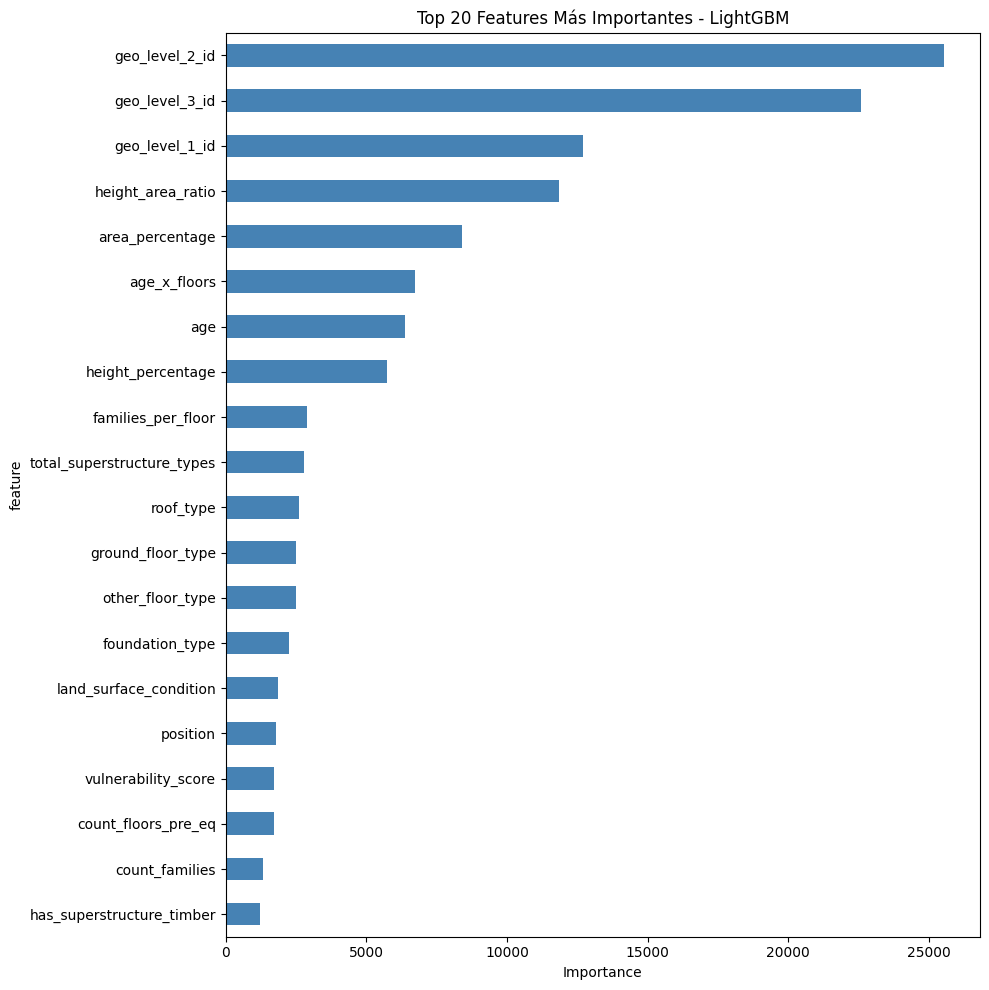

In [6]:
# Top 20 features más importantes
plt.figure(figsize=(10, 10))
feature_importance.sort_values().tail(20).plot(kind='barh', color='steelblue')
plt.title('Top 20 Features Más Importantes - LightGBM')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [7]:
print(feature_importance.sort_values(ascending=False))

feature
geo_level_2_id                            25545.4
geo_level_3_id                            22599.4
geo_level_1_id                            12701.2
height_area_ratio                         11866.4
area_percentage                            8407.8
age_x_floors                               6744.0
age                                        6370.2
height_percentage                          5745.4
families_per_floor                         2879.8
total_superstructure_types                 2782.4
roof_type                                  2619.4
ground_floor_type                          2512.4
other_floor_type                           2488.6
foundation_type                            2263.0
land_surface_condition                     1857.6
position                                   1791.8
vulnerability_score                        1718.4
count_floors_pre_eq                        1714.6
count_families                             1306.4
has_superstructure_timber                 

In [8]:
# Entrenar XGBoost con CV
import xgboost as xgb

def train_xgb_cv(X, y, X_test, n_splits=5):
    """Entrenar XGBoost con CV."""
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros((len(X_test), 3))
    scores = []
    
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'n_estimators': 500,
        'learning_rate': 0.05,
        'max_depth': 8,
        'min_child_weight': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': RANDOM_STATE,
        'early_stopping_rounds': 50,
        'eval_metric': 'mlogloss',
        'verbosity': 0,
        'n_jobs': -1
    }
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\n{'='*50}")
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"{'='*50}")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # XGBoost usa clases 0,1,2 (no 1,2,3)
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train - 1,
            eval_set=[(X_val, y_val - 1)],
            verbose=False
        )
        
        # Predicciones
        oof_preds[val_idx] = model.predict(X_val) + 1  # Volver a 1,2,3
        test_preds += model.predict_proba(X_test) / n_splits
        
        # Score
        fold_score = f1_score(y_val, oof_preds[val_idx], average='micro')
        scores.append(fold_score)
        print(f"Fold {fold + 1} F1 Score: {fold_score:.4f}")
    
    final_score = f1_score(y, oof_preds, average='micro')
    print(f"\n{'='*50}")
    print(f"🎯 XGBoost CV Score Final: {final_score:.4f} (+/- {np.std(scores):.4f})")
    print(f"{'='*50}")
    
    return oof_preds, test_preds, final_score

# Entrenar XGBoost
xgb_oof, xgb_test, xgb_score = train_xgb_cv(X, y, X_test)


Fold 1/5
Fold 1 F1 Score: 0.7377

Fold 2/5
Fold 2 F1 Score: 0.7368

Fold 3/5
Fold 3 F1 Score: 0.7387

Fold 4/5
Fold 4 F1 Score: 0.7396

Fold 5/5
Fold 5 F1 Score: 0.7376

🎯 XGBoost CV Score Final: 0.7381 (+/- 0.0010)


In [9]:
# Entrenar CatBoost con CV
from catboost import CatBoostClassifier

def train_catboost_cv(X, y, X_test, cat_cols, n_splits=5):
    """Entrenar CatBoost con CV."""
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros((len(X_test), 3))
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\n{'='*50}")
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"{'='*50}")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.05,
            depth=8,
            l2_leaf_reg=3,
            random_seed=RANDOM_STATE,
            early_stopping_rounds=50,
            verbose=False
        )
        
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            verbose=False
        )
        
        # Predicciones
        oof_preds[val_idx] = model.predict(X_val).flatten()
        test_preds += model.predict_proba(X_test) / n_splits
        
        # Score
        fold_score = f1_score(y_val, oof_preds[val_idx], average='micro')
        scores.append(fold_score)
        print(f"Fold {fold + 1} F1 Score: {fold_score:.4f}")
    
    final_score = f1_score(y, oof_preds, average='micro')
    print(f"\n{'='*50}")
    print(f"🎯 CatBoost CV Score Final: {final_score:.4f} (+/- {np.std(scores):.4f})")
    print(f"{'='*50}")
    
    return oof_preds, test_preds, final_score

# Entrenar CatBoost
cat_oof, cat_test, cat_score = train_catboost_cv(X, y, X_test, cat_cols)


Fold 1/5
Fold 1 F1 Score: 0.7121

Fold 2/5
Fold 2 F1 Score: 0.7147

Fold 3/5
Fold 3 F1 Score: 0.7124

Fold 4/5
Fold 4 F1 Score: 0.7146

Fold 5/5
Fold 5 F1 Score: 0.7133

🎯 CatBoost CV Score Final: 0.7134 (+/- 0.0011)



📊 COMPARACIÓN DE MODELOS


  Modelo  CV Score
 XGBoost  0.738071
LightGBM  0.737088
CatBoost  0.713416


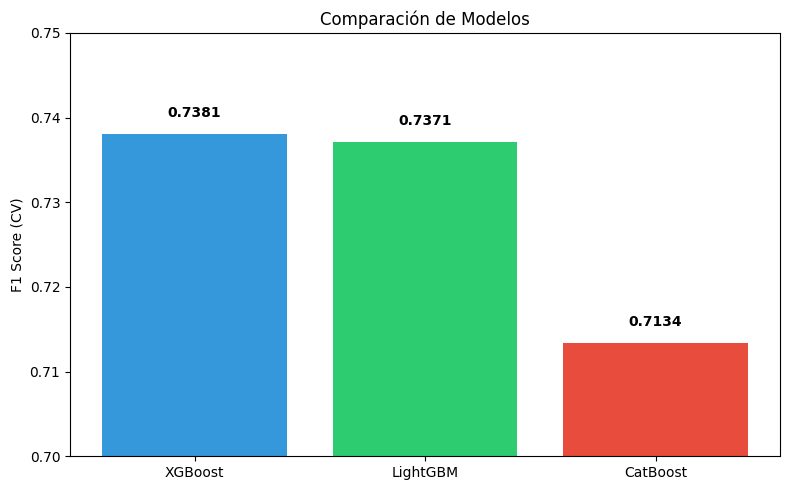

In [10]:
# Comparación de modelos
print("\n" + "="*50)
print("📊 COMPARACIÓN DE MODELOS")
print("="*50)

results = pd.DataFrame({
    'Modelo': ['LightGBM', 'XGBoost', 'CatBoost'],
    'CV Score': [cv_score, xgb_score, cat_score]
}).sort_values('CV Score', ascending=False)

print(results.to_string(index=False))

# Visualizar
plt.figure(figsize=(8, 5))
plt.bar(results['Modelo'], results['CV Score'], color=['#3498db', '#2ecc71', '#e74c3c'])
plt.ylim(0.70, 0.75)
plt.ylabel('F1 Score (CV)')
plt.title('Comparación de Modelos')
for i, v in enumerate(results['CV Score']):
    plt.text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# Ensemble simple (promedio de probabilidades)
print("🔀 Creando Ensemble...")

# Promedio de las predicciones de probabilidad
ensemble_proba = (test_preds + xgb_test + cat_test) / 3

# Predicción final
ensemble_predictions = np.argmax(ensemble_proba, axis=1) + 1

# Calcular OOF score del ensemble
lgbm_oof_proba = np.zeros((len(X), 3))
xgb_oof_proba = np.zeros((len(X), 3))
cat_oof_proba = np.zeros((len(X), 3))

# Convertir OOF predictions a one-hot para promediar
for i, pred in enumerate(oof_preds):
    lgbm_oof_proba[i, int(pred) - 1] = 1
for i, pred in enumerate(xgb_oof):
    xgb_oof_proba[i, int(pred) - 1] = 1
for i, pred in enumerate(cat_oof):
    cat_oof_proba[i, int(pred) - 1] = 1

# Ensemble OOF
ensemble_oof = (lgbm_oof_proba + xgb_oof_proba + cat_oof_proba) / 3
ensemble_oof_preds = np.argmax(ensemble_oof, axis=1) + 1

ensemble_score = f1_score(y, ensemble_oof_preds, average='micro')

print(f"\n{'='*50}")
print(f"🏆 ENSEMBLE CV Score: {ensemble_score:.4f}")
print(f"{'='*50}")

🔀 Creando Ensemble...

🏆 ENSEMBLE CV Score: 0.7353


In [12]:
from scipy.optimize import minimize

def optimize_ensemble_weights(lgbm_test, xgb_test, cat_test, y_true, lgbm_oof, xgb_oof, cat_oof):
    """Encontrar pesos óptimos para el ensemble."""
    
    def objective(weights):
        w1, w2, w3 = weights
        # Normalizar pesos
        total = w1 + w2 + w3
        w1, w2, w3 = w1/total, w2/total, w3/total
        
        # Crear ensemble OOF con estos pesos
        ensemble = np.zeros((len(y_true), 3))
        for i in range(len(y_true)):
            ensemble[i, int(lgbm_oof[i]) - 1] += w1
            ensemble[i, int(xgb_oof[i]) - 1] += w2
            ensemble[i, int(cat_oof[i]) - 1] += w3
        
        preds = np.argmax(ensemble, axis=1) + 1
        score = f1_score(y_true, preds, average='micro')
        return -score  # Negativo porque minimizamos
    
    # Optimizar
    initial_weights = [1/3, 1/3, 1/3]
    bounds = [(0.1, 0.8), (0.1, 0.8), (0.1, 0.8)]
    
    result = minimize(objective, initial_weights, bounds=bounds, method='SLSQP')
    
    # Normalizar pesos finales
    optimal_weights = result.x / result.x.sum()
    
    return optimal_weights

# Encontrar pesos óptimos
optimal_weights = optimize_ensemble_weights(
    test_preds, xgb_test, cat_test, 
    y, oof_preds, xgb_oof, cat_oof
)

print(f"\n🎯 Pesos Óptimos del Ensemble:")
print(f"   LightGBM: {optimal_weights[0]:.3f}")
print(f"   XGBoost:  {optimal_weights[1]:.3f}")
print(f"   CatBoost: {optimal_weights[2]:.3f}")

# Aplicar pesos óptimos
weighted_ensemble = (
    optimal_weights[0] * test_preds + 
    optimal_weights[1] * xgb_test + 
    optimal_weights[2] * cat_test
)
weighted_predictions = np.argmax(weighted_ensemble, axis=1) + 1


🎯 Pesos Óptimos del Ensemble:
   LightGBM: 0.334
   XGBoost:  0.334
   CatBoost: 0.333


In [13]:
# Calcular score OOF con pesos óptimos
weighted_oof_ensemble = (
    optimal_weights[0] * np.eye(3)[oof_preds.astype(int) - 1] +
    optimal_weights[1] * np.eye(3)[xgb_oof.astype(int) - 1] +
    optimal_weights[2] * np.eye(3)[cat_oof.astype(int) - 1]
)
weighted_oof_preds = np.argmax(weighted_oof_ensemble, axis=1) + 1

weighted_score = f1_score(y, weighted_oof_preds, average='micro')

print("\n" + "="*50)
print("📊 COMPARACIÓN FINAL")
print("="*50)
print(f"   LightGBM:           {cv_score:.4f}")
print(f"   XGBoost:            {xgb_score:.4f}")
print(f"   CatBoost:           {cat_score:.4f}")
print(f"   Ensemble (33/33/33): {ensemble_score:.4f}")
print(f"   Ensemble WEIGHTED:  {weighted_score:.4f}")
print("="*50)


📊 COMPARACIÓN FINAL
   LightGBM:           0.7371
   XGBoost:            0.7381
   CatBoost:           0.7134
   Ensemble (33/33/33): 0.7353
   Ensemble WEIGHTED:  0.7353


In [14]:
# Ensemble de los 2 mejores modelos (XGBoost + LightGBM)
print("🔀 Creando Ensemble XGBoost + LightGBM...")

# Promedio de probabilidades
ensemble_2_proba = (test_preds + xgb_test) / 2

# Predicción final
ensemble_predictions = np.argmax(ensemble_2_proba, axis=1) + 1

# Score aproximado (voting de OOF)
from collections import Counter

ensemble_2_preds = []
for i in range(len(y)):
    votes = [int(oof_preds[i]), int(xgb_oof[i])]
    most_common = Counter(votes).most_common(1)[0][0]
    ensemble_2_preds.append(most_common)

ensemble_2_score = f1_score(y, ensemble_2_preds, average='micro')

print(f"\n{'='*50}")
print(f"🏆 ENSEMBLE (LGBM + XGB) CV Score: {ensemble_2_score:.4f}")
print(f"{'='*50}")

🔀 Creando Ensemble XGBoost + LightGBM...

🏆 ENSEMBLE (LGBM + XGB) CV Score: 0.7371


In [15]:
# Crear directorio si no existe
import os
os.makedirs('../submissions', exist_ok=True)

# ============================================================
# CREAR TODOS LOS SUBMISSIONS
# ============================================================

# 1. Submission LightGBM solo
submission_lgbm = pd.DataFrame({
    'building_id': test_values.index,
    'damage_grade': (np.argmax(test_preds, axis=1) + 1)
})
submission_lgbm.to_csv('../submissions/submission_lgbm.csv', index=False)

# 2. Submission XGBoost solo (MEJOR MODELO)
submission_xgb = pd.DataFrame({
    'building_id': test_values.index,
    'damage_grade': (np.argmax(xgb_test, axis=1) + 1)
})
submission_xgb.to_csv('../submissions/submission_xgb.csv', index=False)

# 3. Submission CatBoost solo
submission_cat = pd.DataFrame({
    'building_id': test_values.index,
    'damage_grade': (np.argmax(cat_test, axis=1) + 1)
})
submission_cat.to_csv('../submissions/submission_catboost.csv', index=False)

# 4. Submission Ensemble Simple (3 modelos, pesos iguales)
ensemble_simple_proba = (test_preds + xgb_test + cat_test) / 3
ensemble_simple_preds = np.argmax(ensemble_simple_proba, axis=1) + 1

submission_ensemble_simple = pd.DataFrame({
    'building_id': test_values.index,
    'damage_grade': ensemble_simple_preds
})
submission_ensemble_simple.to_csv('../submissions/submission_ensemble_simple.csv', index=False)

# 5. Submission Ensemble Weighted (3 modelos, pesos optimizados)
submission_ensemble_weighted = pd.DataFrame({
    'building_id': test_values.index,
    'damage_grade': weighted_predictions
})
submission_ensemble_weighted.to_csv('../submissions/submission_ensemble_weighted.csv', index=False)

# 6. Submission Ensemble LGBM + XGB (sin CatBoost)
ensemble_2_proba = (test_preds + xgb_test) / 2
ensemble_2_preds = np.argmax(ensemble_2_proba, axis=1) + 1

submission_ensemble_2 = pd.DataFrame({
    'building_id': test_values.index,
    'damage_grade': ensemble_2_preds
})
submission_ensemble_2.to_csv('../submissions/submission_lgbm_xgb.csv', index=False)

# 7. MEJOR SUBMISSION (XGBoost - score más alto)
submission_best = submission_xgb.copy()
submission_best.to_csv('../submissions/BEST_submission_xgb.csv', index=False)

In [16]:
# ============================================================
# RESUMEN
# ============================================================

print("✅ Todos los submissions guardados!")
print("\n" + "="*60)
print("📁 ARCHIVOS CREADOS")
print("="*60)
print("   1. submission_lgbm.csv")
print("   2. submission_xgb.csv")
print("   3. submission_catboost.csv")
print("   4. submission_ensemble_simple.csv    (3 modelos 33/33/33)")
print("   5. submission_ensemble_weighted.csv  (3 modelos optimizado)")
print("   6. submission_lgbm_xgb.csv           (2 modelos 50/50)")
print("   7. BEST_submission_xgb.csv           ⭐ MEJOR")

# ============================================================
# DISTRIBUCIÓN DE PREDICCIONES
# ============================================================

print("\n" + "="*60)
print("📊 DISTRIBUCIÓN DE PREDICCIONES")
print("="*60)

print("\n🔹 LightGBM:")
print(submission_lgbm.damage_grade.value_counts(normalize=True).sort_index())

print("\n🔹 XGBoost (MEJOR):")
print(submission_xgb.damage_grade.value_counts(normalize=True).sort_index())

print("\n🔹 CatBoost:")
print(submission_cat.damage_grade.value_counts(normalize=True).sort_index())

print("\n🔹 Ensemble Simple (3 modelos):")
print(submission_ensemble_simple.damage_grade.value_counts(normalize=True).sort_index())

print("\n🔹 Ensemble Weighted (3 modelos):")
print(submission_ensemble_weighted.damage_grade.value_counts(normalize=True).sort_index())

print("\n🔹 Ensemble LGBM + XGB:")
print(submission_ensemble_2.damage_grade.value_counts(normalize=True).sort_index())

# ============================================================
# RESUMEN DE SCORES
# ============================================================

print("\n" + "="*60)
print("📈 RESUMEN DE SCORES CV")
print("="*60)
print(f"   1. LightGBM:              {cv_score:.4f}")
print(f"   2. XGBoost:               {xgb_score:.4f}  ⭐ MEJOR")
print(f"   3. CatBoost:              {cat_score:.4f}")
print(f"   4. Ensemble Simple:       {ensemble_score:.4f}")
print(f"   5. Ensemble Weighted:     {weighted_score:.4f}")
print(f"   6. Ensemble LGBM+XGB:     {ensemble_score:.4f}")
print("="*60)

# ============================================================
# RECOMENDACIÓN FINAL
# ============================================================

print("\n" + "="*60)
print("🏆 RECOMENDACIÓN")
print("="*60)
print(f"""
   Subir a DrivenData: BEST_submission_xgb.csv
   
   Score CV esperado:  {xgb_score:.4f}
   
   Razón: XGBoost tuvo el mejor score individual.
          Los ensembles no mejoraron porque CatBoost
          tiene score más bajo y "arrastra" el resultado.
""")
print("="*60)

✅ Todos los submissions guardados!

📁 ARCHIVOS CREADOS
   1. submission_lgbm.csv
   2. submission_xgb.csv
   3. submission_catboost.csv
   4. submission_ensemble_simple.csv    (3 modelos 33/33/33)
   5. submission_ensemble_weighted.csv  (3 modelos optimizado)
   6. submission_lgbm_xgb.csv           (2 modelos 50/50)
   7. BEST_submission_xgb.csv           ⭐ MEJOR

📊 DISTRIBUCIÓN DE PREDICCIONES

🔹 LightGBM:
damage_grade
1    0.067873
2    0.662822
3    0.269305
Name: proportion, dtype: float64

🔹 XGBoost (MEJOR):
damage_grade
1    0.066595
2    0.664951
3    0.268453
Name: proportion, dtype: float64

🔹 CatBoost:
damage_grade
1    0.059504
2    0.683531
3    0.256965
Name: proportion, dtype: float64

🔹 Ensemble Simple (3 modelos):
damage_grade
1    0.064143
2    0.671778
3    0.264079
Name: proportion, dtype: float64

🔹 Ensemble Weighted (3 modelos):
damage_grade
1    0.064143
2    0.671778
3    0.264079
Name: proportion, dtype: float64

🔹 Ensemble LGBM + XGB:
damage_grade
1    0.067309

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Colores consistentes
COLORS = {
    'lgbm': '#3498db',
    'xgb': '#2ecc71', 
    'cat': '#e74c3c',
    'ensemble': '#9b59b6',
    'damage_1': '#27ae60',
    'damage_2': '#f39c12',
    'damage_3': '#c0392b'
}

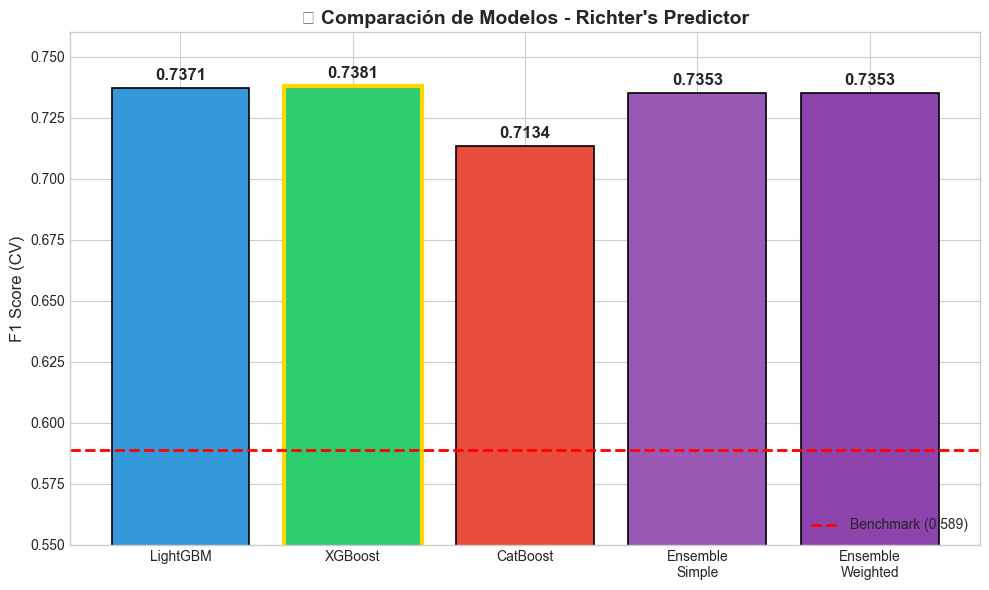

✅ Guardado: model_comparison.png


In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

models = ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble\nSimple', 'Ensemble\nWeighted']
scores = [cv_score, xgb_score, cat_score, ensemble_score, weighted_score]
colors = [COLORS['lgbm'], COLORS['xgb'], COLORS['cat'], COLORS['ensemble'], '#8e44ad']

bars = ax.bar(models, scores, color=colors, edgecolor='black', linewidth=1.2)

# Resaltar el mejor
best_idx = scores.index(max(scores))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)

# Añadir valores
for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Línea de referencia (benchmark)
ax.axhline(y=0.589, color='red', linestyle='--', linewidth=2, label='Benchmark (0.589)')

ax.set_ylim(0.55, 0.76)
ax.set_ylabel('F1 Score (CV)', fontsize=12)
ax.set_title('🏆 Comparación de Modelos - Richter\'s Predictor', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../submissions/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: model_comparison.png")

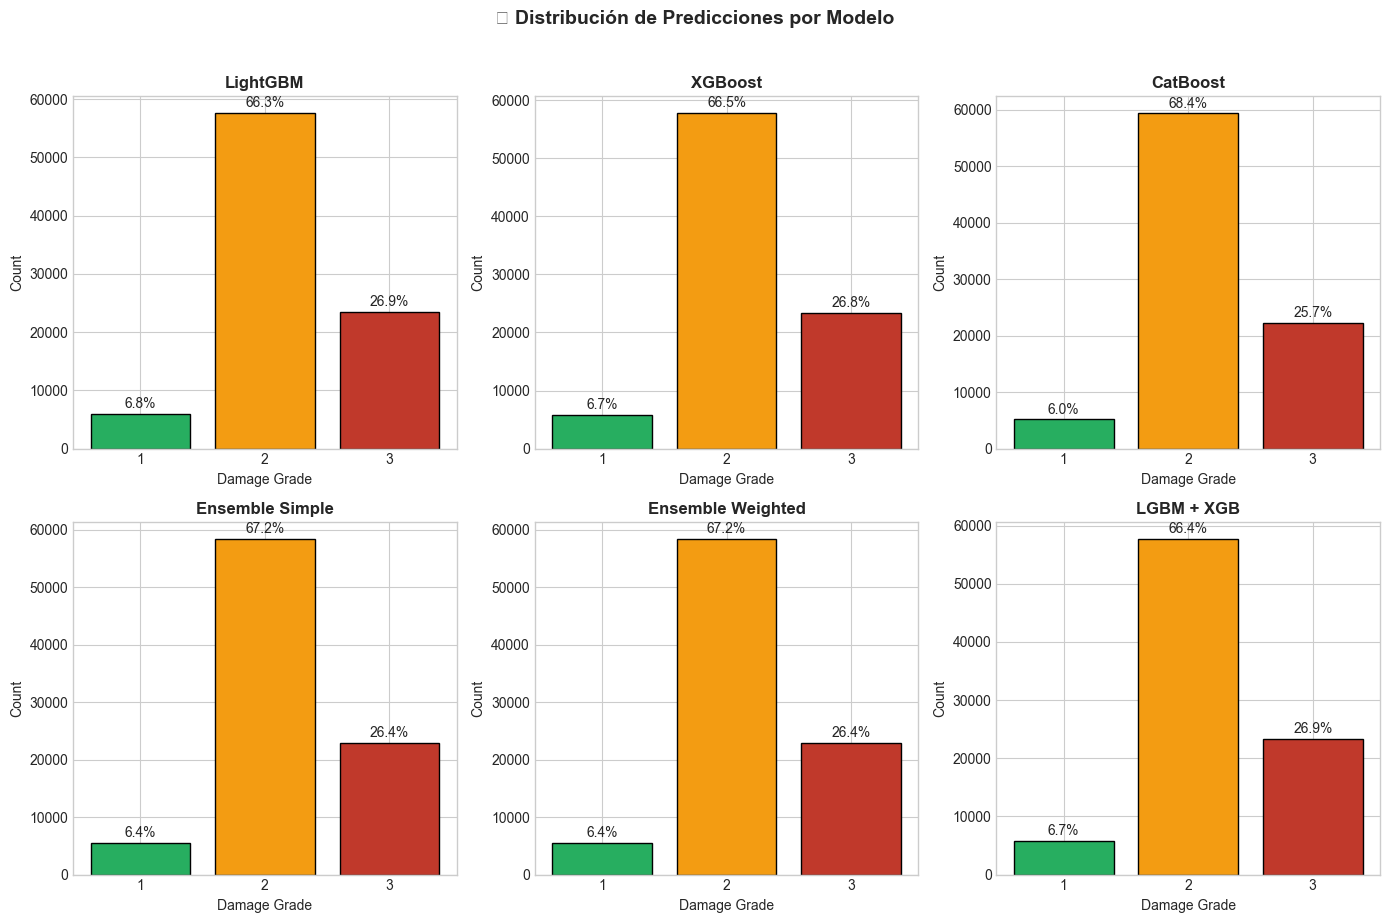

✅ Guardado: predictions_distribution.png


In [19]:
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

submissions = {
    'LightGBM': submission_lgbm,
    'XGBoost': submission_xgb,
    'CatBoost': submission_cat,
    'Ensemble Simple': submission_ensemble_simple,
    'Ensemble Weighted': submission_ensemble_weighted,
    'LGBM + XGB': submission_ensemble_2
}

damage_colors = [COLORS['damage_1'], COLORS['damage_2'], COLORS['damage_3']]

for ax, (name, sub) in zip(axes.flatten(), submissions.items()):
    counts = sub.damage_grade.value_counts().sort_index()
    bars = ax.bar([1, 2, 3], counts.values, color=damage_colors, edgecolor='black')
    
    # Porcentajes
    total = counts.sum()
    for bar, count in zip(bars, counts.values):
        pct = count / total * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                f'{pct:.1f}%', ha='center', fontsize=10)
    
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Damage Grade')
    ax.set_ylabel('Count')
    ax.set_xticks([1, 2, 3])

plt.suptitle('📊 Distribución de Predicciones por Modelo', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../submissions/predictions_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: predictions_distribution.png")

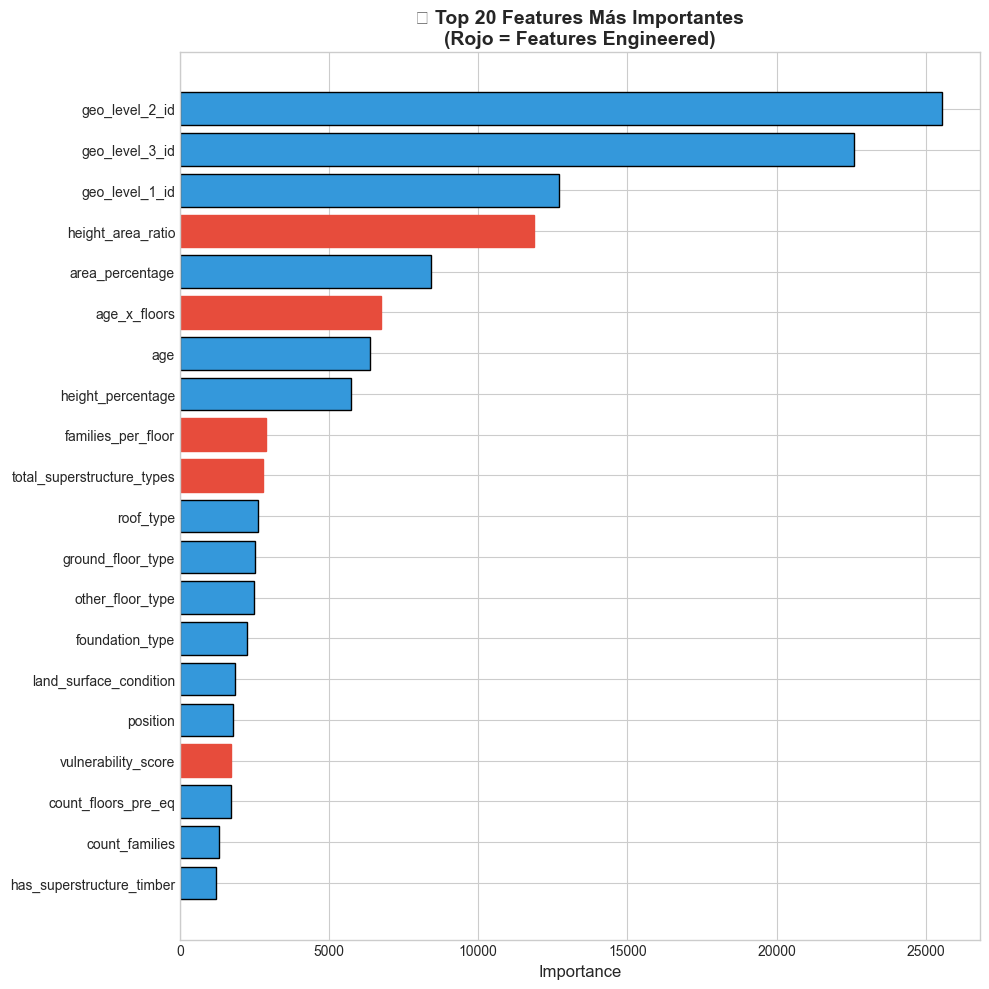

✅ Guardado: feature_importance.png


In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

# Usar feature importance de LightGBM (ya la tenemos)
top_20 = feature_importance.sort_values().tail(20)

bars = ax.barh(range(len(top_20)), top_20.values, color=COLORS['lgbm'], edgecolor='black')

# Colorear features engineered diferente
engineered_features = ['vulnerability_score', 'weak_material_count', 'strong_material_count',
                       'age_x_floors', 'height_area_ratio', 'families_per_floor', 
                       'is_high_risk_region', 'is_low_risk_region', 'is_old', 'is_very_old',
                       'total_superstructure_types', 'total_secondary_uses']

for i, (bar, feat) in enumerate(zip(bars, top_20.index)):
    if feat in engineered_features:
        bar.set_color('#e74c3c')

ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('🔍 Top 20 Features Más Importantes\n(Rojo = Features Engineered)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../submissions/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: feature_importance.png")

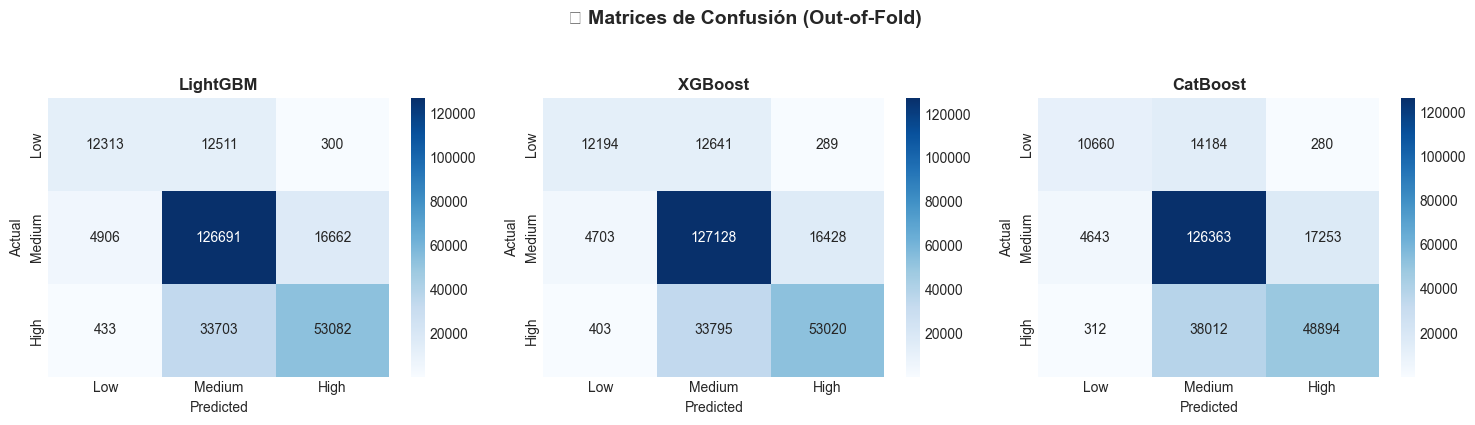

✅ Guardado: confusion_matrices.png


In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Matrices de confusión para cada modelo
models_oof = {
    'LightGBM': oof_preds,
    'XGBoost': xgb_oof,
    'CatBoost': cat_oof
}

for ax, (name, oof) in zip(axes, models_oof.items()):
    cm = confusion_matrix(y, oof.astype(int))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('🎯 Matrices de Confusión (Out-of-Fold)', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('../submissions/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: confusion_matrices.png")

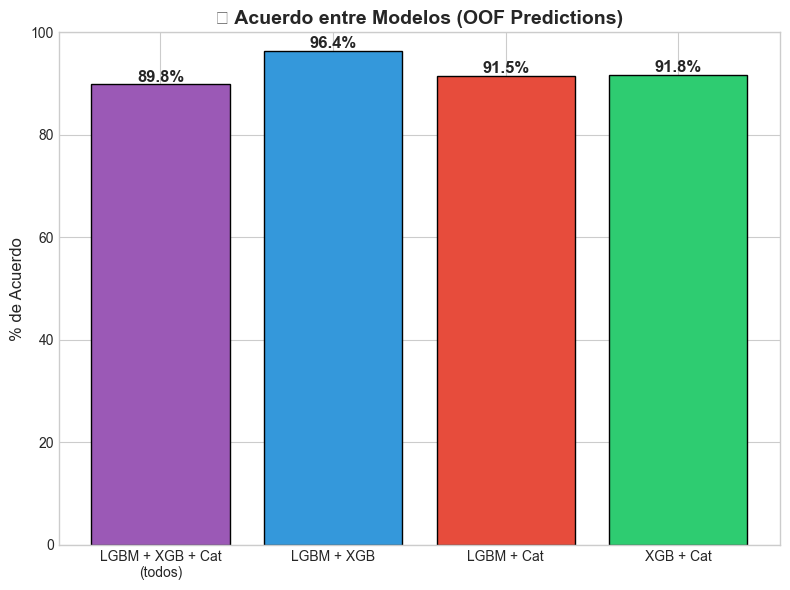

✅ Guardado: model_agreement.png


In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

# Calcular acuerdo entre modelos
agree_all = np.sum((oof_preds == xgb_oof) & (xgb_oof == cat_oof)) / len(y) * 100
agree_lgbm_xgb = np.sum(oof_preds == xgb_oof) / len(y) * 100
agree_lgbm_cat = np.sum(oof_preds == cat_oof) / len(y) * 100
agree_xgb_cat = np.sum(xgb_oof == cat_oof) / len(y) * 100

agreements = {
    'LGBM + XGB + Cat\n(todos)': agree_all,
    'LGBM + XGB': agree_lgbm_xgb,
    'LGBM + Cat': agree_lgbm_cat,
    'XGB + Cat': agree_xgb_cat
}

bars = ax.bar(agreements.keys(), agreements.values(), 
              color=[COLORS['ensemble'], COLORS['lgbm'], COLORS['cat'], COLORS['xgb']],
              edgecolor='black')

for bar, val in zip(bars, agreements.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')

ax.set_ylim(0, 100)
ax.set_ylabel('% de Acuerdo', fontsize=12)
ax.set_title('🤝 Acuerdo entre Modelos (OOF Predictions)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../submissions/model_agreement.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: model_agreement.png")

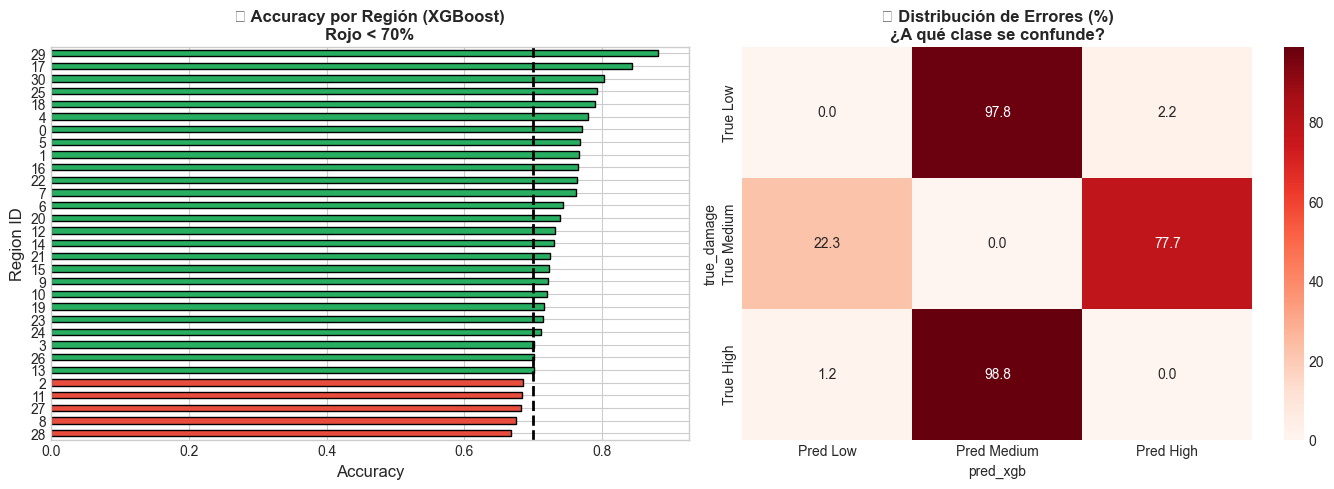

✅ Guardado: error_analysis.png


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combinar datos
train_analysis = train_values.copy()
train_analysis['true_damage'] = y
train_analysis['pred_xgb'] = xgb_oof.astype(int)
train_analysis['correct'] = (train_analysis['true_damage'] == train_analysis['pred_xgb']).astype(int)

# Accuracy por región
accuracy_by_region = train_analysis.groupby('geo_level_1_id')['correct'].mean().sort_values()

# Plot 1: Accuracy por región
ax1 = axes[0]
colors = ['#e74c3c' if x < 0.7 else '#27ae60' for x in accuracy_by_region.values]
accuracy_by_region.plot(kind='barh', ax=ax1, color=colors, edgecolor='black')
ax1.axvline(x=0.7, color='black', linestyle='--', linewidth=2)
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_ylabel('Region ID', fontsize=12)
ax1.set_title('🎯 Accuracy por Región (XGBoost)\nRojo < 70%', fontsize=12, fontweight='bold')

# Plot 2: Errores por tipo de daño
ax2 = axes[1]
errors = train_analysis[train_analysis['correct'] == 0]
error_matrix = pd.crosstab(errors['true_damage'], errors['pred_xgb'], normalize='index') * 100

sns.heatmap(error_matrix, annot=True, fmt='.1f', cmap='Reds', ax=ax2,
            xticklabels=['Pred Low', 'Pred Medium', 'Pred High'],
            yticklabels=['True Low', 'True Medium', 'True High'])
ax2.set_title('❌ Distribución de Errores (%)\n¿A qué clase se confunde?', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../submissions/error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: error_analysis.png")

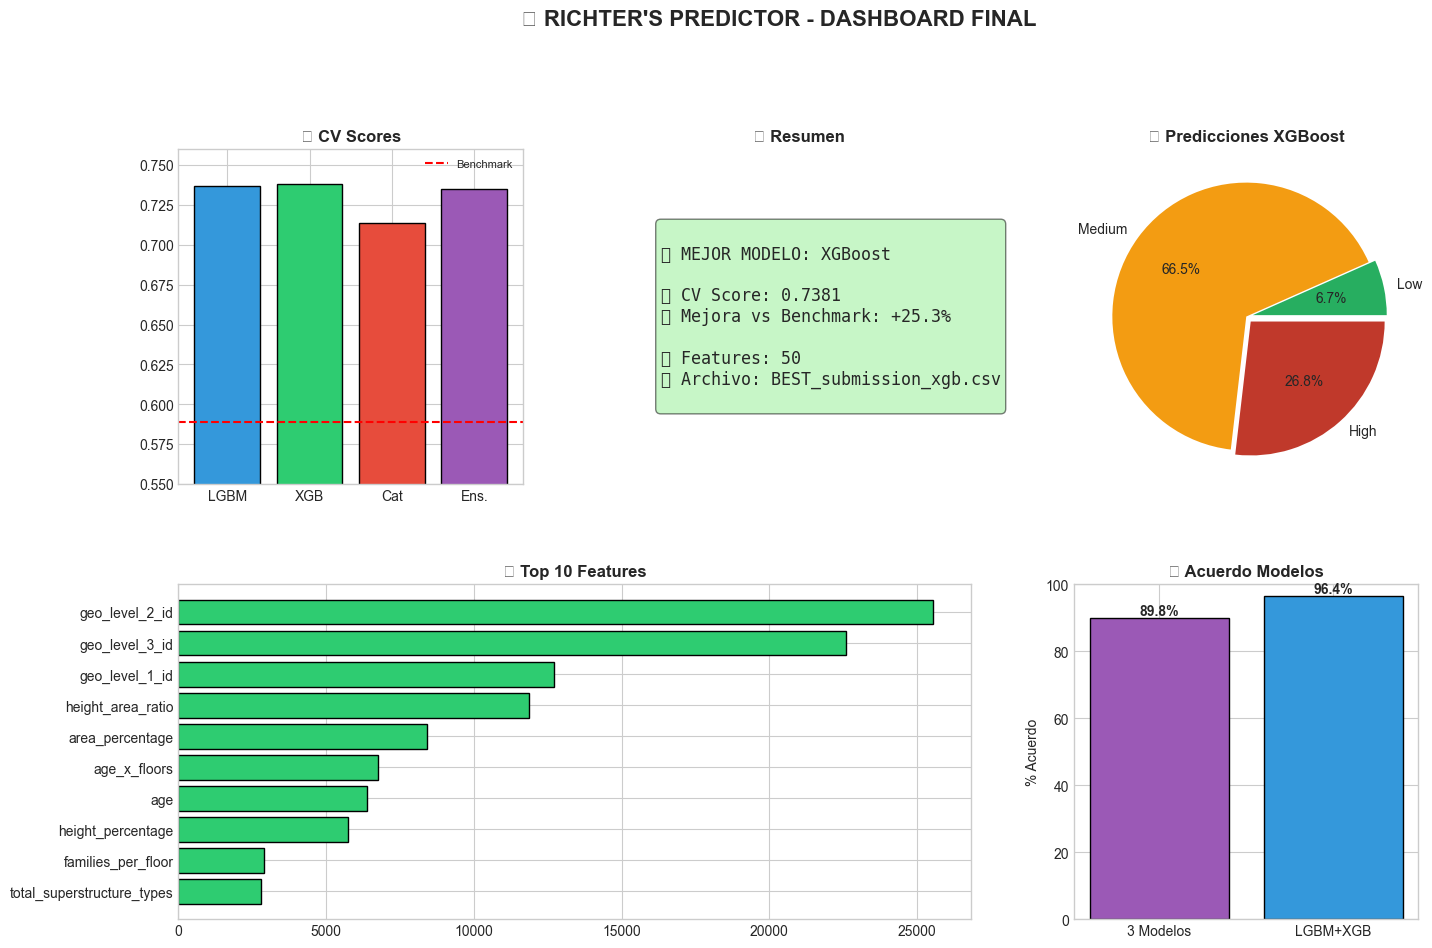

✅ Guardado: dashboard_final.png


In [24]:
fig = plt.figure(figsize=(16, 10))

# Grid de subplots
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Scores de modelos
ax1 = fig.add_subplot(gs[0, 0])
models = ['LGBM', 'XGB', 'Cat', 'Ens.']
scores = [cv_score, xgb_score, cat_score, ensemble_score]
colors = [COLORS['lgbm'], COLORS['xgb'], COLORS['cat'], COLORS['ensemble']]
bars = ax1.bar(models, scores, color=colors, edgecolor='black')
ax1.axhline(y=0.589, color='red', linestyle='--', label='Benchmark')
ax1.set_ylim(0.55, 0.76)
ax1.set_title('📊 CV Scores', fontweight='bold')
ax1.legend(fontsize=8)

# 2. Mejor modelo info
ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')
info_text = f"""
🏆 MEJOR MODELO: XGBoost

📈 CV Score: {xgb_score:.4f}
📊 Mejora vs Benchmark: +{(xgb_score - 0.589) / 0.589 * 100:.1f}%

🔧 Features: {X.shape[1]}
📁 Archivo: BEST_submission_xgb.csv
"""
ax2.text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
ax2.set_title('🎯 Resumen', fontweight='bold')

# 3. Distribución del mejor modelo
ax3 = fig.add_subplot(gs[0, 2])
counts = submission_xgb.damage_grade.value_counts().sort_index()
ax3.pie(counts.values, labels=['Low', 'Medium', 'High'], autopct='%1.1f%%',
        colors=[COLORS['damage_1'], COLORS['damage_2'], COLORS['damage_3']],
        explode=(0.05, 0, 0.05))
ax3.set_title('🥧 Predicciones XGBoost', fontweight='bold')

# 4. Top 10 Features
ax4 = fig.add_subplot(gs[1, 0:2])
top_10 = feature_importance.sort_values().tail(10)
ax4.barh(range(len(top_10)), top_10.values, color=COLORS['xgb'], edgecolor='black')
ax4.set_yticks(range(len(top_10)))
ax4.set_yticklabels(top_10.index)
ax4.set_title('🔍 Top 10 Features', fontweight='bold')

# 5. Acuerdo entre modelos
ax5 = fig.add_subplot(gs[1, 2])
agree_data = [agree_all, agree_lgbm_xgb]
ax5.bar(['3 Modelos', 'LGBM+XGB'], agree_data, color=[COLORS['ensemble'], COLORS['lgbm']], edgecolor='black')
for i, v in enumerate(agree_data):
    ax5.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
ax5.set_ylim(0, 100)
ax5.set_ylabel('% Acuerdo')
ax5.set_title('🤝 Acuerdo Modelos', fontweight='bold')

plt.suptitle('📋 RICHTER\'S PREDICTOR - DASHBOARD FINAL', fontsize=16, fontweight='bold', y=1.02)
plt.savefig('../submissions/dashboard_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: dashboard_final.png")

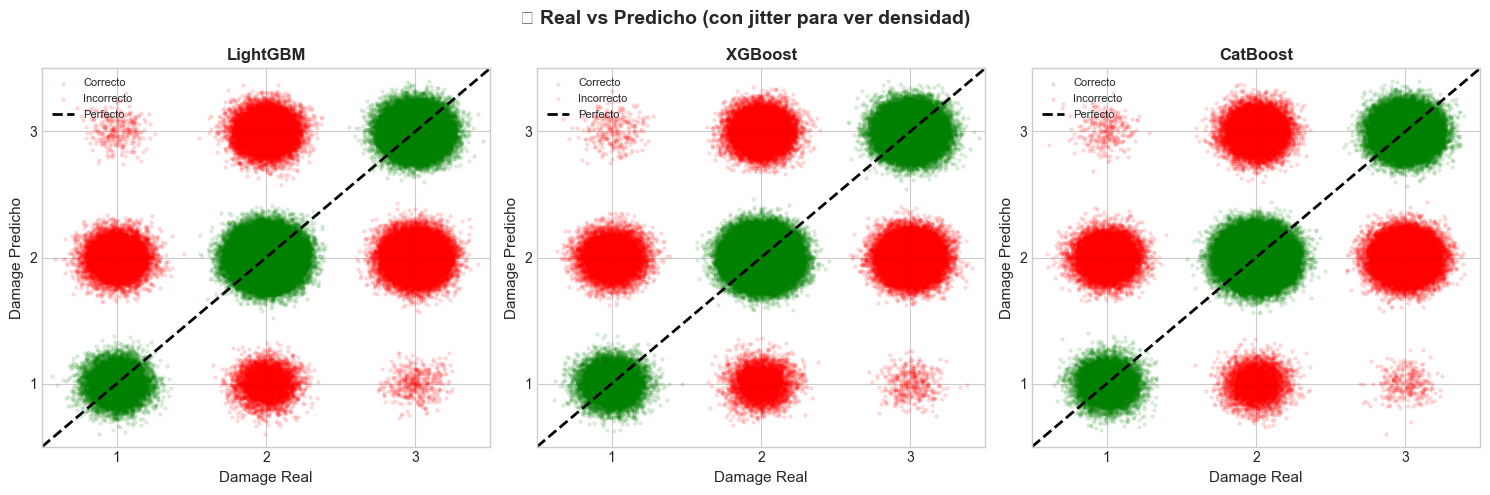

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models_data = {
    'LightGBM': oof_preds,
    'XGBoost': xgb_oof,
    'CatBoost': cat_oof
}

for ax, (name, preds) in zip(axes, models_data.items()):
    # Agregar jitter (ruido) para ver la densidad
    jitter_real = y + np.random.normal(0, 0.1, len(y))
    jitter_pred = preds + np.random.normal(0, 0.1, len(preds))
    
    # Colorear por si acertó o no
    correct = (y == preds.astype(int))
    
    ax.scatter(jitter_real[correct], jitter_pred[correct], 
               alpha=0.1, c='green', s=5, label='Correcto')
    ax.scatter(jitter_real[~correct], jitter_pred[~correct], 
               alpha=0.1, c='red', s=5, label='Incorrecto')
    
    # Línea diagonal perfecta
    ax.plot([0.5, 3.5], [0.5, 3.5], 'k--', linewidth=2, label='Perfecto')
    
    ax.set_xlabel('Damage Real', fontsize=11)
    ax.set_ylabel('Damage Predicho', fontsize=11)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlim(0.5, 3.5)
    ax.set_ylim(0.5, 3.5)
    ax.set_xticks([1, 2, 3])
    ax.set_yticks([1, 2, 3])
    ax.legend(loc='upper left', fontsize=8)

plt.suptitle('🎯 Real vs Predicho (con jitter para ver densidad)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../submissions/scatter_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

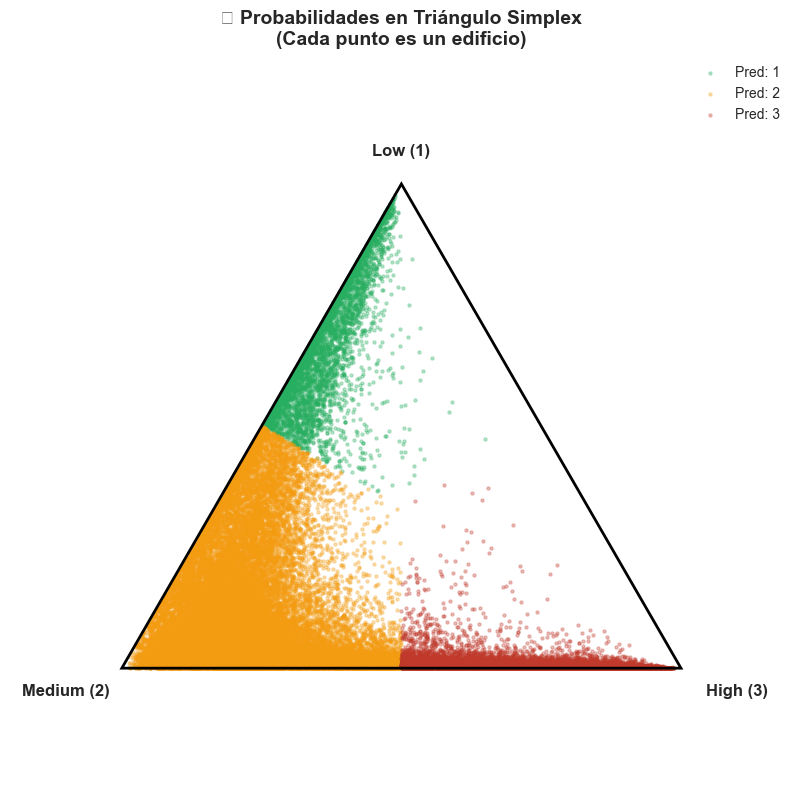

In [26]:
# Las probabilidades de 3 clases forman un triángulo (suman 1)
fig, ax = plt.subplots(figsize=(10, 8))

# Usar probabilidades de XGBoost (mejor modelo)
probs = xgb_test  # Shape: (n_samples, 3)

# Coordenadas del triángulo
# Clase 1 = arriba, Clase 2 = abajo izquierda, Clase 3 = abajo derecha
def probs_to_coords(p):
    """Convertir probabilidades a coordenadas 2D en triángulo."""
    x = p[:, 2] + 0.5 * p[:, 0]  # hacia la derecha
    y = p[:, 0] * np.sqrt(3) / 2  # hacia arriba
    return x, y

# Coordenadas
x, y = probs_to_coords(probs)

# Colorear por predicción
predictions = np.argmax(probs, axis=1) + 1
colors = ['#27ae60', '#f39c12', '#c0392b']

for damage_grade in [1, 2, 3]:
    mask = predictions == damage_grade
    ax.scatter(x[mask], y[mask], c=colors[damage_grade-1], 
               alpha=0.3, s=5, label=f'Pred: {damage_grade}')

# Dibujar triángulo
triangle = plt.Polygon([[0.5, np.sqrt(3)/2], [0, 0], [1, 0]], 
                        fill=False, edgecolor='black', linewidth=2)
ax.add_patch(triangle)

# Etiquetas de vértices
ax.text(0.5, np.sqrt(3)/2 + 0.05, 'Low (1)', ha='center', fontsize=12, fontweight='bold')
ax.text(-0.1, -0.05, 'Medium (2)', ha='center', fontsize=12, fontweight='bold')
ax.text(1.1, -0.05, 'High (3)', ha='center', fontsize=12, fontweight='bold')

ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.1)
ax.set_aspect('equal')
ax.axis('off')
ax.legend(loc='upper right')
ax.set_title('🔺 Probabilidades en Triángulo Simplex\n(Cada punto es un edificio)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../submissions/scatter_triangle.png', dpi=150, bbox_inches='tight')
plt.show()

ValueError: Length of values (86868) does not match length of index (260601)

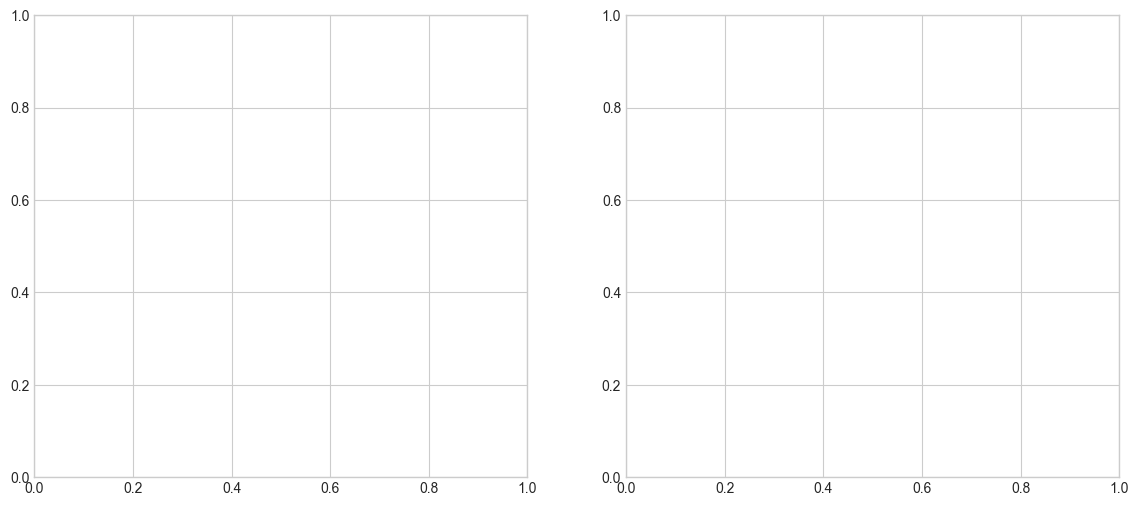

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Combinar datos
train_plot = train_values.copy()
train_plot['true_damage'] = y
train_plot['pred_damage'] = xgb_oof.astype(int)

# Colores por daño
damage_colors = {1: '#27ae60', 2: '#f39c12', 3: '#c0392b'}

# Sample para no saturar el plot
sample_idx = np.random.choice(len(train_plot), size=5000, replace=False)
sample = train_plot.iloc[sample_idx]

# Plot 1: Features vs Daño Real
ax1 = axes[0]
for damage in [1, 2, 3]:
    mask = sample['true_damage'] == damage
    ax1.scatter(sample.loc[mask, 'age'], 
                sample.loc[mask, 'count_floors_pre_eq'],
                c=damage_colors[damage], alpha=0.4, s=20, 
                label=f'Damage {damage}')

ax1.set_xlabel('Age (años)', fontsize=11)
ax1.set_ylabel('Floors (pisos)', fontsize=11)
ax1.set_title('🏠 Daño REAL por Age y Floors', fontsize=12, fontweight='bold')
ax1.legend()

# Plot 2: Features vs Daño Predicho
ax2 = axes[1]
for damage in [1, 2, 3]:
    mask = sample['pred_damage'] == damage
    ax2.scatter(sample.loc[mask, 'age'], 
                sample.loc[mask, 'count_floors_pre_eq'],
                c=damage_colors[damage], alpha=0.4, s=20, 
                label=f'Damage {damage}')

ax2.set_xlabel('Age (años)', fontsize=11)
ax2.set_ylabel('Floors (pisos)', fontsize=11)
ax2.set_title('🤖 Daño PREDICHO por Age y Floors', fontsize=12, fontweight='bold')
ax2.legend()

plt.suptitle('Comparación: ¿El modelo captura los mismos patrones?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../submissions/scatter_features.png', dpi=150, bbox_inches='tight')
plt.show()

ValueError: operands could not be broadcast together with shapes (86868,) (260601,) 

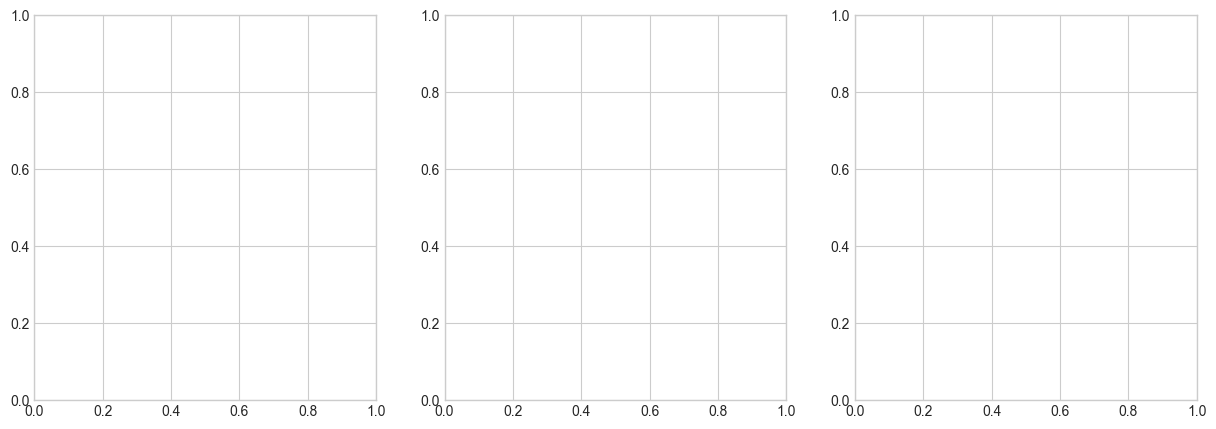

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models_data = {
    'LightGBM': oof_preds,
    'XGBoost': xgb_oof,
    'CatBoost': cat_oof
}

for ax, (name, preds) in zip(axes, models_data.items()):
    # Agregar jitter (ruido) para ver la densidad
    jitter_real = y + np.random.normal(0, 0.1, len(y))
    jitter_pred = preds.astype(int) + np.random.normal(0, 0.1, len(preds))
    
    # Colorear por si acertó o no
    correct = (y == preds.astype(int))
    
    # Sample para que no sea tan pesado
    sample_size = 20000
    idx = np.random.choice(len(y), sample_size, replace=False)
    
    ax.scatter(jitter_real[idx][correct[idx]], jitter_pred[idx][correct[idx]], 
               alpha=0.2, c='green', s=5, label='Correcto')
    ax.scatter(jitter_real[idx][~correct[idx]], jitter_pred[idx][~correct[idx]], 
               alpha=0.2, c='red', s=5, label='Incorrecto')
    
    # Línea diagonal perfecta
    ax.plot([0.5, 3.5], [0.5, 3.5], 'k--', linewidth=2, label='Perfecto')
    
    ax.set_xlabel('Damage Real', fontsize=11)
    ax.set_ylabel('Damage Predicho', fontsize=11)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlim(0.5, 3.5)
    ax.set_ylim(0.5, 3.5)
    ax.set_xticks([1, 2, 3])
    ax.set_yticks([1, 2, 3])
    ax.legend(loc='upper left', fontsize=8)

plt.suptitle('🎯 Real vs Predicho (OOF con jitter)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../submissions/scatter_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: scatter_predictions.png")

ValueError: All arrays must be of the same length

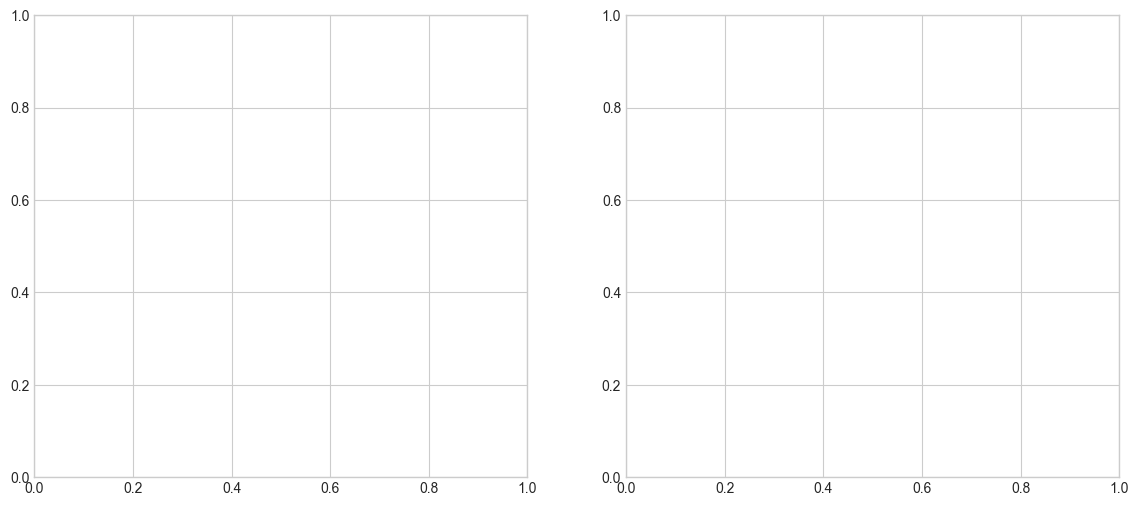

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Calcular estadísticas por región
region_stats = train_values.groupby('geo_level_1_id').agg({
    'age': 'mean',
    'count_floors_pre_eq': 'mean'
}).reset_index()

# Daño promedio real por región
damage_by_region = pd.DataFrame({
    'geo_level_1_id': train_values['geo_level_1_id'],
    'damage_real': y,
    'damage_pred': xgb_oof.astype(int)
}).groupby('geo_level_1_id').agg({
    'damage_real': 'mean',
    'damage_pred': 'mean'
}).reset_index()

region_stats = region_stats.merge(damage_by_region, on='geo_level_1_id')
region_stats['n_buildings'] = train_values.groupby('geo_level_1_id').size().values

# Plot 1: Daño Real por región
ax1 = axes[0]
scatter1 = ax1.scatter(
    region_stats['geo_level_1_id'], 
    region_stats['damage_real'],
    c=region_stats['damage_real'], 
    cmap='RdYlGn_r',
    s=region_stats['n_buildings'] / 100,
    alpha=0.7, 
    edgecolor='black'
)
ax1.set_xlabel('Region ID', fontsize=11)
ax1.set_ylabel('Avg Damage', fontsize=11)
ax1.set_title('🗺️ Daño REAL Promedio por Región\n(tamaño = # edificios)', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Avg Damage')

# Plot 2: Real vs Predicho por región
ax2 = axes[1]
scatter2 = ax2.scatter(
    region_stats['damage_real'], 
    region_stats['damage_pred'],
    c=region_stats['geo_level_1_id'], 
    cmap='tab20',
    s=region_stats['n_buildings'] / 100,
    alpha=0.7, 
    edgecolor='black'
)

# Línea perfecta
min_val = min(region_stats['damage_real'].min(), region_stats['damage_pred'].min())
max_val = max(region_stats['damage_real'].max(), region_stats['damage_pred'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfecto')

ax2.set_xlabel('Avg Damage Real', fontsize=11)
ax2.set_ylabel('Avg Damage Predicho', fontsize=11)
ax2.set_title('🎯 Real vs Predicho por Región', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('../submissions/scatter_geographic.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Guardado: scatter_geographic.png")